In [125]:
from bitalg.visualizer.main import Visualizer
from typing import Tuple, List
from data import raw
from data.raw import EPSILON, P0
from numpy import sign
from functools import cmp_to_key

In [126]:
class Node:
    def __init__(self, x: float, y: float):
        # coordinates
        self.x = x
        self.y = y

        # neighbours
        self.nodesOut = []  # (Node,weight)
        self.nodesIn = []  # (Node,weight)

        # for weight processing
        self.wIn = 0
        self.wOut = 0

    def __str__(self) -> str:
        return f"{self.x,self.y}"

    def __repr__(self):
        return f"{self.x,self.y}"
class Separator:
    def __init__(self):
        self.points = []
    def add_point(self, point):
        self.points.append(point)
    def getpoints(self):
        return self.point


def loadData(
    vertices: List[Tuple[float, float]], edges: List[Tuple[int, int]]
) -> List[Node]:  # zakladam, ze wierzcholki sa juz posortowane rosnaco
    """Loads data from raw.py file"""
    Nodes = [Node(x, y) for (x, y) in vertices]

    for i, j in edges:
        # validate input, so that i<j
        i, j = sorted([i, j])

        # initialize weights with 1's
        Nodes[i].nodesOut.append((Nodes[j], 1))
        Nodes[j].nodesIn.append((Nodes[i], 1))

    return Nodes

In [127]:
def sortEdges(vertices: List[Node]):
    """Sorts edges from rightmost to leftmost"""
    global P0
    for vertex in vertices:
        P0 = (vertex.x, vertex.y)
        vertex.nodesOut.sort(key=cmp_to_key(cmp1))
        vertex.nodesIn.sort(key=cmp_to_key(cmp2))


def det(a, b, c):
    result = (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])
    return result


def cmp1(n1: Tuple[Node, int], n2: Tuple[Node, int]):
    b = (n1[0].x, n1[0].y)
    c = (n2[0].x, n2[0].y)
    d = det(P0, b, c)
    if abs(d) < EPSILON:
        raise ValueError("Two edges with the same angle")
    else:
        return sign(-d)


def cmp2(n1: Tuple[Node, int], n2: Tuple[Node, int]):
    b = (n1[0].x, n1[0].y)
    c = (n2[0].x, n2[0].y)
    d = det(P0, b, c)
    if abs(d) < EPSILON:
        raise ValueError("Two edges with the same angle")
    else:
        return sign(d)

In [128]:
def calculateWeights(vertices: List[Node]):
    sortEdges(vertices)
    
    calculate(vertices)
    


def calculate(vertices: List[Node]):
    for vertex in vertices[1:-1]:  # without first and last vertex
        vertex.wIn = sum([w for (_, w) in vertex.nodesIn])
        vertex.wOut = len([w for (_, w) in vertex.nodesOut])

        if vertex.wIn > vertex.wOut:
            # v - leftmost Node
            (v, w) = vertex.nodesOut.pop()
            vertex.nodesOut.append((v, w + vertex.wIn - vertex.wOut))
            # change in v's nodesIn
            idx = v.nodesIn.index((vertex, w))
            v.nodesIn[idx] = (vertex, w + vertex.wIn - vertex.wOut)
            
    for vertex in reversed(vertices[1:-1]):  # without first and last vertex
        #vertex.wIn = sum([w for (_, w) in vertex.nodesIn])
        vertex.wOut = sum([w for (_, w) in vertex.nodesOut])

        if vertex.wOut > vertex.wIn:
            # v - leftmost Node
            (v, w) = vertex.nodesIn.pop()
            vertex.nodesIn.append((v, w + vertex.wOut - vertex.wIn))
            # change in v's nodesIn
            idx = v.nodesOut.index((vertex, w))
            v.nodesOut[idx] = (vertex, w + vertex.wOut - vertex.wIn)

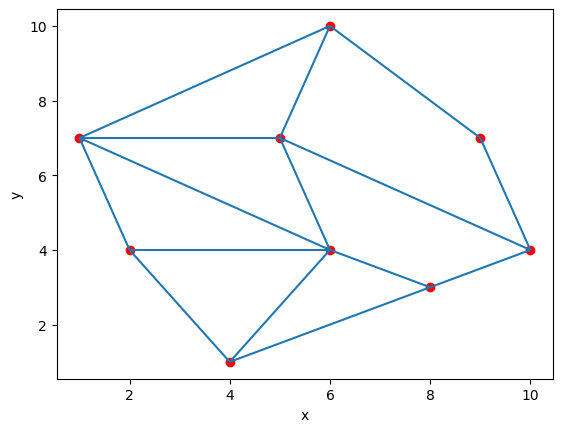

In [129]:
vertices=loadData(raw.vertices,raw.edges)
# visualize graph
vis=Visualizer()
points=[(n.x,n.y) for n in vertices]
segments=[]
for n in vertices:
    for out in n.nodesOut:
        segments.append(((n.x,n.y),(out[0].x,out[0].y)))
vis.add_point(points,color='red')
vis.add_line_segment(segments)
vis.show()

In [130]:
calculateWeights(vertices)
for vertex in vertices:
    print(f"VERTEX {vertex.x,vertex.y}")
    print("IN: ",end="")
    for (n,w) in vertex.nodesIn:
        print(f"{n} {w}",end=" | ")
    print()
    print("OUT: ",end="")
    for (n,w) in vertex.nodesOut:
        print(f"{n} {w}",end=" | ")
    print()


VERTEX (4, 1)
IN: 
OUT: (8, 3) 3 | (6, 4) 1 | (2, 4) 2 | 
VERTEX (8, 3)
IN: (4, 1) 3 | 
OUT: (10, 4) 2 | (6, 4) 1 | 
VERTEX (2, 4)
IN: (4, 1) 2 | 
OUT: (6, 4) 1 | (1, 7) 1 | 
VERTEX (6, 4)
IN: (8, 3) 1 | (4, 1) 1 | (2, 4) 1 | 
OUT: (5, 7) 1 | (1, 7) 2 | 
VERTEX (10, 4)
IN: (8, 3) 2 | 
OUT: (9, 7) 1 | (5, 7) 1 | 
VERTEX (1, 7)
IN: (6, 4) 2 | (2, 4) 1 | 
OUT: (5, 7) 1 | (6, 10) 2 | 
VERTEX (5, 7)
IN: (10, 4) 1 | (6, 4) 1 | (1, 7) 1 | 
OUT: (6, 10) 3 | 
VERTEX (9, 7)
IN: (10, 4) 1 | 
OUT: (6, 10) 1 | 
VERTEX (6, 10)
IN: (9, 7) 1 | (5, 7) 3 | (1, 7) 2 | 
OUT: 


In [131]:
def find_separators(graph):
    def go_thru_separator(vertice,separator):
        
        separator.append((vertice.x,vertice.y))
        out=vertice.nodesOut
        if not out:
            return separator
        i=0
        while out[i][1]==0 :
            i+=1
        
        out[i]=(out[i][0],out[i][1]-1)
        return go_thru_separator(out[i][0],separator)
        
    
    n=sum([w for (_, w) in graph[0].nodesOut])
    separators=[[] for i in range(n)]
    for i in range(n):
        separators[i]=go_thru_separator(graph[0],[])
    separator_edges=[[]for i in range(n)]
    for i in range(n):
        for o in range(len(separators[i])-1):
            separator_edges[i].append((separators[i][o],separators[i][o+1]))
    return separators,separator_edges

In [132]:
separators_vertices,separator_edges=find_separators(vertices)


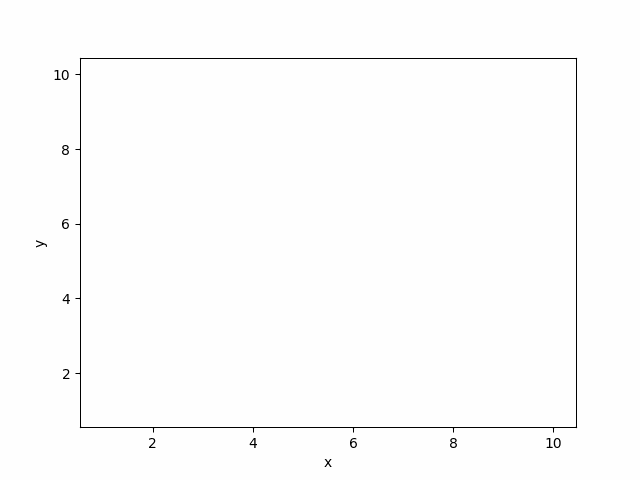

In [134]:
for separator in separator_edges:
    to_remove=vis.add_line_segment(separator,color="black")
    vis.remove_figure(to_remove)
vis.show_gif(interval=500)